<a href="https://colab.research.google.com/github/jcuesta123/TFM-RL/blob/main/new_helicopter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IMPORTS
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
state = np.array([0., 0., 0., 0., 0., 0.]) # x,y,v_x,v_y,T,theta
num_features = state.size
num_actions = 5 # nothing, more traction, less traction, more angle, less angle
print(num_features, num_actions)

6 5


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class DQN(nn.Module):
    """Dense neural network class."""
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 32)
        self.fc2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, num_actions)

    def forward(self, states):
        """Forward pass."""
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        return self.out(x)

main_nn = DQN(num_features, num_actions).to(device)
target_nn = DQN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [5]:
class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size, device="cpu"):
    """Initializes the buffer."""
    self.buffer = deque(maxlen=size)
    self.device = device

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = torch.as_tensor(np.array(states), device=self.device)
    actions = torch.as_tensor(np.array(actions), device=self.device)
    rewards = torch.as_tensor(np.array(rewards, dtype=np.float32), device=self.device
    )
    next_states = torch.as_tensor(np.array(next_states), device=self.device)
    dones = torch.as_tensor(np.array(dones, dtype=np.float32), device=self.device)
    return states, actions, rewards, next_states, dones

In [75]:
np.random.uniform()

0.5641229345338772

In [6]:
def select_epsilon_greedy_action(state, epsilon):
  """Take random action with probability epsilon, else take best action."""
  result = np.random.uniform()

  if result < epsilon:
    return random.randint(0, num_actions-1)
  else:
    qs = main_nn(state).cpu().data.numpy()
    return np.argmax(qs) # Greedy action for state.

In [7]:
def train_step(states, actions, rewards, next_states, dones):
  """Perform a training iteration on a batch of data sampled from the experience
  replay buffer.
  """
  # Calculate targets.
  max_next_qs = target_nn(next_states).max(-1).values
  target = rewards + (1.0 - dones) * discount * max_next_qs
  qs = main_nn(states)
  action_masks = F.one_hot(actions, num_actions)
  masked_qs = (action_masks * qs).sum(dim=-1)
  loss = loss_fn(masked_qs, target.detach())
  #nn.utils.clip_grad_norm_(loss, max_norm=10)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [8]:
state = np.array([0., 0., 0., 0., 0., 0.]).astype(np.float64)
type(state)

numpy.ndarray

In [38]:
max_action_space[0]/10

2.0

In [78]:
g = 10
m_h = 1
deltaT = 0.1

max_action_space = np.array([2*m_h*g, math.pi/4])
min_action_space = np.array([0, -math.pi/4])

#environment, based on pyhsics, num. computation and conditionals
def environment(state, action):

  new_state = state
  done = False

  #TERMINATE TRAINING conditions
  #On ground - in flight
  if state[1] < 0.01 and state[3] < -3:   # crash into ground
    done = True
  elif state[0] < -100 or state[0] > 200 or state[1] > 200:  # out of limits
    done = True
  else:
    pass

  #processing action
  if action == 1:
    new_state[4] = state[4] + max_action_space[0]/10
  elif action == 2:
    new_state[4] = state[4] - max_action_space[0]/10
  elif action == 3:
    new_state[5] = state[5] + max_action_space[1]/10
  elif action == 4:
    new_state[5] = state[5] - max_action_space[1]/10
  else: #action == 0
    pass

  #to not surpass limits
  if new_state[4] > max_action_space[0]:
    new_state[4] = max_action_space[0]
  elif new_state[4] < min_action_space[0]:
    new_state[4] = min_action_space[0]
  elif new_state[5] > max_action_space[1]:
    new_state[5] = max_action_space[1]
  elif new_state[5] < min_action_space[1]:
    new_state[5] = min_action_space[1]
  else:
    pass

  #Mechanics
  #Forces
  a_x = new_state[4]*math.sin(new_state[5])/m_h
  a_y = new_state[4]*math.cos(new_state[5])/m_h - g

  #Velocities
  new_state[2] = new_state[2] + deltaT*a_x
  new_state[3] = new_state[3] + deltaT*a_y

  #Positions
  new_state[0] = new_state[0] + deltaT*new_state[2]
  new_state[1] = new_state[1] + deltaT*new_state[3]

  if new_state[1] < 0.01 and new_state[4]*math.cos(new_state[5]) < m_h*g:
    a_x = 0.
    a_y = 0.
    new_state[1] = 0.
    new_state[2] = 0.
    new_state[3] = 0.

  reward = reward_function(new_state, dest)

  return new_state, reward, done

In [10]:
dest = np.array([50, 10])

def reward_function(new_state, dest):

  reward = np.linalg.norm(dest) - math.sqrt((dest[0]-state[0])**2+(dest[1]-state[1])**2)

  return reward

In [61]:
#PRINT TRAJECTORY

def plot_traj(matrix_info):

  t = matrix_info[:,6]

  x = matrix_info[:, 0]
  y = matrix_info[:, 1]
  v_x = matrix_info[:, 2]
  v_y = matrix_info[:, 3]
  T = matrix_info[:, 4]
  theta = matrix_info[:, 5]
  r = matrix_info[:, 7]


  plt.subplot(3, 2, 1)  # 2 filas, 1 columna, primera posición
  plt.plot(x, y)  # 'r--' indica línea roja discontinua
  plt.scatter(dest[0],dest[1])
  plt.title('Trayectory (m)')
  plt.xlabel('Axis X')
  plt.ylabel('Axis Y')
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)

  # Graficamos las velocidades en función del tiempo
  plt.subplot(3, 2, 2)  # 2 filas, 1 columna, primera posición
  plt.title('Velocities (m/s)')
  plt.plot(t, v_x, label='V_x (blue)', color='blue')
  plt.plot(t, v_y, label='V_y (red)', color='red')
  plt.legend()
  plt.grid(True)

  # Graficamos las velocidades en función del tiempo
  plt.subplot(3, 2, 3)  # 2 filas, 1 columna, primera posición
  plt.title('Traction(N)')
  plt.plot(t, T, label='T', color='blue')
  plt.grid(True)

  # Graficamos las velocidades en función del tiempo
  plt.subplot(3, 2, 4)  # 2 filas, 1 columna, primera posición
  plt.title('Cumulative reward')
  plt.plot(t, r, label='Reward', color='blue')
  plt.grid(True)

  # Graficamos las velocidades en función del tiempo
  plt.subplot(3, 2, 5)  # 2 filas, 1 columna, primera posición
  plt.title('Theta(rad)')
  plt.plot(t, theta, label='theta', color='red')
  plt.grid(True)


  plt.tight_layout()
  plt.show()

In [81]:
# TRAIN MODEL

# Hyperparameters.
num_episodes = 1000
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000, device=device)
cur_frame = 0

# Start training. Play game once and then train with a batch.
last_100_ep_rewards = []
for episode in range(num_episodes+1):
  state = np.array([0., 50., 0., 0., 12., 0.]).astype(np.float32)
  ep_reward, done = 0, False
  while not done:

    if cur_frame > 1000:
      break
    state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
    action = select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done = environment(state, action)
    next_state = next_state.astype(np.float32)
    ep_reward += reward
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1
    # Copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      target_nn.load_state_dict(main_nn.state_dict())

    # Train neural network.
    if len(buffer) > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = train_step(states, actions, rewards, next_states, dones)

  if episode < 950:
    epsilon -= 0.001

  if len(last_100_ep_rewards) == 100:
    last_100_ep_rewards = last_100_ep_rewards[1:]
  last_100_ep_rewards.append(ep_reward)

  if episode % 50 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
          f' Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.2f}')
    print(state)


Episode 0/1000. Epsilon: 0.999. Reward in last 100 episodes: -1852.30
[-104.44514     81.88231    -35.91569     21.865168     6.
   -0.6283185]
Episode 50/1000. Epsilon: 0.949. Reward in last 100 episodes: -509.55
[ 0. 50.  0.  0. 12.  0.]
Episode 100/1000. Epsilon: 0.899. Reward in last 100 episodes: -241.35
[ 0. 50.  0.  0. 12.  0.]
Episode 150/1000. Epsilon: 0.849. Reward in last 100 episodes: 0.00
[ 0. 50.  0.  0. 12.  0.]
Episode 200/1000. Epsilon: 0.799. Reward in last 100 episodes: 0.00
[ 0. 50.  0.  0. 12.  0.]
Episode 250/1000. Epsilon: 0.749. Reward in last 100 episodes: 0.00
[ 0. 50.  0.  0. 12.  0.]
Episode 300/1000. Epsilon: 0.699. Reward in last 100 episodes: 0.00
[ 0. 50.  0.  0. 12.  0.]
Episode 350/1000. Epsilon: 0.649. Reward in last 100 episodes: 0.00
[ 0. 50.  0.  0. 12.  0.]
Episode 400/1000. Epsilon: 0.599. Reward in last 100 episodes: 0.00
[ 0. 50.  0.  0. 12.  0.]
Episode 450/1000. Epsilon: 0.549. Reward in last 100 episodes: 0.00
[ 0. 50.  0.  0. 12.  0.]
Episo

In [63]:
max_action_space

array([20.        ,  0.78539816])

episode terminated at frame:  1001


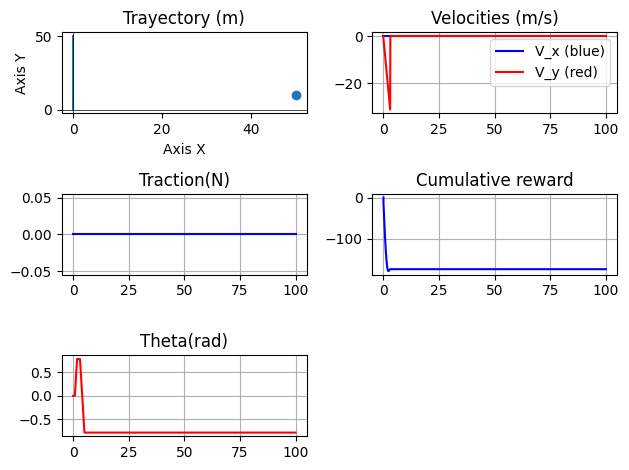

In [84]:
# FINAL SIMULATION, AFTER NN TRAINING

epsilon = 0
cur_frame = 0
time = 0

state = np.array([0., 50., 0., 0., 0., 0.]).astype(np.float32)
matrix_info = np.concatenate((state, [time], [0]))
ep_reward, done = 0, False

while not done:

  if cur_frame > 1000:
    break
  state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
  action = select_epsilon_greedy_action(state_in, epsilon)
  next_state, reward, done = environment(state, action)
  next_state = next_state.astype(np.float32)
  ep_reward += reward
  time = deltaT * cur_frame

  matrix_info = np.vstack([matrix_info, np.concatenate((state, [time], [ep_reward]))])

  state = next_state
  cur_frame += 1

print('episode terminated at frame: ', cur_frame)
plot_traj(matrix_info)